# 15 - Exploration of Historical NBA Players (Part VI, PCA to Explore Historical Lineups)
Last time, I explored 9 regions of our PCA bi-plot. I'll review what I thought the 9 regions represented here:
- Region 1: All-Star Guards
- Region 2: All-Star Scorers
- Region 3: All-Star Big Men
- Region 4: Great Guards
- Region 5: Great All-Around / Two-Way Players
- Region 6: Great Big Men
- Region 7: Spot Up Shooters
- Region 8: Weakest Players
- Region 9: Big Men Beasts (Who Can't Score)

Looking through this data in this way, one thing that kinda hit me was when I went through region 7 and saw all the players that have played with Lebron over the seasons show up in this region. Different players have different skill sets. Your star player has a certain skill set. While you'd like him to do everything, he may or may not. You have to build your team around him. Lebron can do it all, so perhaps all you need are shooters around him. Perhaps the same could be said for Harden or Curry, but of course each of these guys come with their own caveats as well.

As a refresher, here are what the regions in the PCA bi-plot looked like:
![](https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/pca_plot_basic_metric_cluster.png)

I can't say I'm 100% confident in this plot. As I left off last time, PCA is giving us one perspective of the game. The numbers perspective. Whether it speaks to what you see on the court is another story. Of course, getting "philisophical" again, the numbers will speak to what the numbers will speak to, and that's all it can do. My dataframe is 13k some odd rows and when I first scraped the data out of bball-ref, I got like, what, 30 features? This is finite. I have 13k x 30 data points, period.

When I'm watching a game, I'm probably keeping somewhat of a "soft" dataframe in my head. The dataframe changes, it grows, shrinks, changes dimension, changes scales on the fly while I watch the game. How many points does Kobe have this game? 40? Crazy. How does this rank this season? Pretty high! How are his teammates doing? Not much support this game eh... Every question requires me constructing somewhat of a dataframe in my head. An on-the-fly dataframe that's almost an art. Can't hold nearly enough data, but it's got the _**flexibility**_ that we try to emulate with python and R. When you're watching a game, you also get _**more data**_. You can see how picks are being set, you can see how switches are getting caught up, you can see how _**hard**_ people are playing. These may not even be quantifiable metrics (okay, the Engineer in me says everything is quantifiable), but they are not measured in the data set that we have. Again, we're creating these data points on the fly, quantifying them in even an emotional way that makes sense to us in the process.

Even then, simply watching a game even has limits in the data. We don't know what the players are thinking. We don't know what the coach is drawing up. We don't know whether the ref has a vendetta out for any players today. We don't know if a guy partied too hard last night or had some bad food for lunch. Each _**player**_ doesn't even have all the data available, but of course, that's what makes this a _**game**_. Strategizing and planning and executing to see if you can put yourself in a better position to win the next game. Only one guy has _**all**_ the data that we could possibly be interested in, and that's the man upstairs, the basketball God.

Sorry for that. That actually really has nothing to do with what I'm about to say, but I feel I had to get that out there haha. Anyways, what I was **ABOUT** to say was that, yeah, I'm not confident in this PCA model in terms of interpretability to me. We're trying to cram, again, really an infinite amount of data into 2 dimensions. Sure, I took 10 or whatever features, but realistically each of these depend on an infinite number of other things as well, including each other. And, sure, I get it right, this is a _**dimension reduction**_ model, I wouldn't be using it if I didn't want to see the data in this way, but just looking at some of these axis, they don't make sense to me in _**two dimensions**_. I just get the sense that I'm trying to cram too much into these two dimensions, and the data is just so much more complex than that that the takeaways here are _**incorrect**_.

I feel like much of this is a biproduct of the game changing and evolving. PCA is a **blueprint** to look at this data, but again, we're trying to say a whole paragraph in 2 words. Something's gotta give.

Before I try to refine this model, let's just take a look at how some teams are constructed using this plot. I'm going to plot the top 10 players on each team in terms of minutes played to see how teams are distributed in terms of types of players.

In [1]:
%load_ext rpy2.ipython

In [48]:
%%R
# Load libraries & initial config
library(ggplot2)
library(gridExtra)
library(scales)
library(ggbiplot)

In [3]:
# Load libraries & initial config
%matplotlib nbagg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from StringIO import StringIO
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Retrieve team stats from S3
playerAggDfToAnalyze = pd.read_csv('https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/data/playerAggDfToAnalyze.csv', index_col = 0)

pd.set_option('display.max_rows', len(playerAggDfToAnalyze.dtypes))
print playerAggDfToAnalyze.dtypes
pd.reset_option('display.max_rows')

season_start_year          int64
perGameStats_Player       object
perGameStats_Pos          object
perGameStats_Age           int64
perGameStats_Tm           object
perGameStats_G             int64
perGameStats_GS          float64
perGameStats_MP          float64
per100Stats_FG           float64
per100Stats_FGA          float64
per100Stats_FGPerc       float64
per100Stats_3P           float64
per100Stats_3PA          float64
per100Stats_3PPerc       float64
per100Stats_2P           float64
per100Stats_2PA          float64
per100Stats_2PPerc       float64
per100Stats_FT           float64
per100Stats_FTA          float64
per100Stats_FTPerc       float64
per100Stats_ORB          float64
per100Stats_DRB          float64
per100Stats_TRB          float64
per100Stats_AST          float64
per100Stats_STL          float64
per100Stats_BLK          float64
per100Stats_TOV          float64
per100Stats_PF           float64
per100Stats_PTS          float64
per100Stats_ORtg         float64
per100Stat

In [5]:
# Filter to remove outliers, player must have played over 10 minutes and in over 20 games on the season
playerAggDfToAnalyzeMin10Min20Games = playerAggDfToAnalyze[(playerAggDfToAnalyze['perGameStats_MP'] > 10) & (playerAggDfToAnalyze['perGameStats_G'] > 20)]

From a python / R perspective, nothing really changes with what we want to do. In the past, the labels we pass to R's ggbiplot function to color the points by group have been by position. This data was just data we pulled from the original data frame itself from basketball reference in the column **perGameStats\_Pos**. Now we just have to pass it the player name, but the logic has changed such that we want each player in the starting lineup of interest in its own group, and the rest of the ~13k players in an "Other" group or something like that. We can try to write a function so we can just pass it the season we want, the team we want, and the function will do the following
1. Calculate the top players in terms of MP per team
2. Craft the labels and the data to perform PCA on

In [443]:
# Define a function to take in a year and a team, the function will calculate who the starters are, perform the PCA transformation
#   and then plot the starters on the PCA plot
def teamPlayerBiplot(seasonStartYear, team):
    # Select subset of features
    playerAggDfToAnalyzeMin10Min20GamesPCAFeatures = playerAggDfToAnalyzeMin10Min20Games[[
        'season_start_year',
        'perGameStats_Tm',
        'perGameStats_Player',
        'perGameStats_MP',
        'perGameStats_GS',
        'per100Stats_FGA',
        'per100Stats_3PA',
        'per100Stats_2PA',
        'per100Stats_2PPerc',
        'per100Stats_FTA',
        'per100Stats_FTPerc',
        'per100Stats_ORB',
        'per100Stats_DRB',
        'per100Stats_AST',
        'per100Stats_STL',
        'per100Stats_BLK',
        'per100Stats_TOV',
        'per100Stats_PF',
        'per100Stats_PTS'
    ]].dropna().reset_index(drop = True)
    
    # Create a copy of the dataframe with shorter name for readability
    pcaFeaturesDf = playerAggDfToAnalyzeMin10Min20GamesPCAFeatures
    
    # Calculate the 5 players on the given team with the most games started, get their index into a list
    startersDfIndexes = pcaFeaturesDf[
        (pcaFeaturesDf['season_start_year'] == seasonStartYear) & (pcaFeaturesDf['perGameStats_Tm'] == team)
    ].sort_values(
        'perGameStats_MP',
        ascending = False
    ).head(10).index.tolist()
    
    # Print the starters statlines
    playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesStatlines = playerAggDfToAnalyzeMin10Min20GamesPCAFeatures[playerAggDfToAnalyzeMin10Min20GamesPCAFeatures.index.isin(startersDfIndexes)][[
        'perGameStats_Player',
        'perGameStats_MP',
        'per100Stats_PTS',
        'per100Stats_FGA',
        'per100Stats_2PA',
        'per100Stats_2PPerc',
        'per100Stats_3PA',
        'per100Stats_FTA',
        'per100Stats_FTPerc',
        'per100Stats_ORB',
        'per100Stats_DRB',
        'per100Stats_AST',
        'per100Stats_STL',
        'per100Stats_BLK',
        'per100Stats_TOV',
        'per100Stats_PF'
    ]]

    # For those players found, output them to the label to pass to ggbiplot, otherwise label to blank category
    playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesLabel = np.where(
        playerAggDfToAnalyzeMin10Min20GamesPCAFeatures.index.isin(startersDfIndexes),
        playerAggDfToAnalyzeMin10Min20GamesPCAFeatures['perGameStats_Player'],
        ''
    ).tolist()
    
    size = playerAggDfToAnalyzeMin10Min20GamesPCAFeatures['per100Stats_PTS'].tolist()
    
    # Structure data to pass to R's prcomp()
    playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesData = playerAggDfToAnalyzeMin10Min20GamesPCAFeatures.drop(['season_start_year', 'perGameStats_Tm', 'perGameStats_Player', 'perGameStats_GS', 'perGameStats_MP'], 1)
    
    # Return labels and data to pass to R
    return size, playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesStatlines, playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesLabel, playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesData

In [466]:
%%R

pcaPlayerBiplot = function(size, labels, data){
    pca = prcomp(data, center = T, scale = T)
    ggbiplot(pca, obs.scale = 1, var.scale = 1, circle = TRUE, alpha = 1, groups = labels, labels = labels)
}

## 2016 GSW

Let's take a look at the 2016 dubs.

In [467]:
size, statlines, labels, data = teamPlayerBiplot(2016, 'GSW')
statlines

,perGameStats_Player,perGameStats_MP,per100Stats_PTS,per100Stats_FGA,per100Stats_2PA,per100Stats_2PPerc,per100Stats_3PA,per100Stats_FTA,per100Stats_FTPerc,per100Stats_ORB,per100Stats_DRB,per100Stats_AST,per100Stats_STL,per100Stats_BLK,per100Stats_TOV,per100Stats_PF
12331,Ian Clark,14.7,22.6,18.4,11.5,0.556,6.9,2.5,0.759,1.0,4.1,3.8,1.6,0.3,2.3,3.3
12343,Stephen Curry,33.5,36.5,26.3,12.0,0.538,14.3,6.6,0.899,1.1,5.3,9.5,2.6,0.3,4.3,3.4
12364,Kevin Durant,33.5,35.9,23.8,16.6,0.607,7.2,9.0,0.879,0.9,11.0,7.0,1.5,2.3,3.2,2.7
12404,Draymond Green,32.5,15.1,12.7,7.6,0.492,5.1,4.1,0.709,1.9,9.8,10.4,3.0,2.0,3.6,4.2
12447,Andre Iguodala,26.3,13.8,10.0,5.7,0.651,4.3,2.5,0.706,1.2,6.1,6.3,1.8,0.9,1.4,2.3
12501,Shaun Livingston,17.7,14.1,11.4,11.2,0.555,0.1,2.2,0.700,1.0,4.4,5.0,1.3,0.7,2.2,4.4
12513,Patrick McCaw,14.9,12.4,10.7,5.3,0.530,5.4,1.6,0.771,0.9,3.5,3.5,1.5,0.6,1.6,2.8
12557,Zaza Pachulia,18.2,16.1,11.6,11.6,0.535,0.0,4.8,0.774,5.2,10.2,5.0,2.3,1.2,3.4,6.4
12626,Klay Thompson,34.1,31.7,25.0,13.2,0.517,11.8,3.9,0.855,0.9,4.3,2.9,1.2,0.7,2.3,2.6
12650,David West,12.5,18.0,14.3,13.8,0.544,0.5,3.2,0.768,2.5,8.9,8.6,2.3,2.8,4.2,5.8


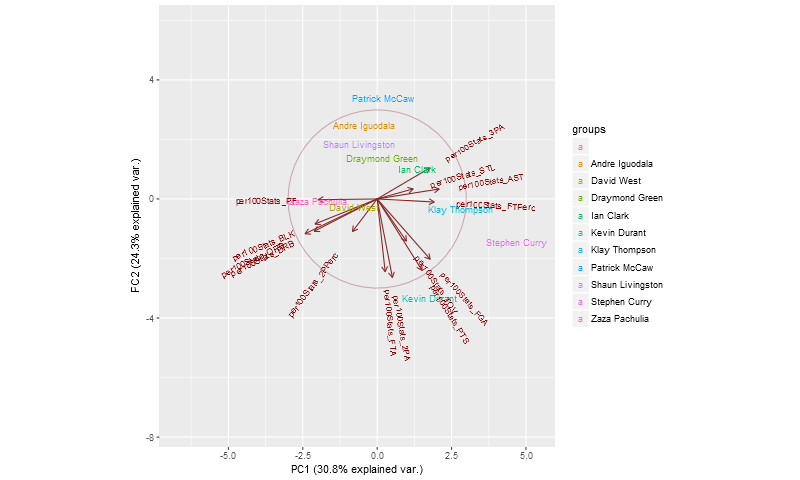

In [468]:
%%R -i labels -i data -i size -w 800 -u px
pcaPlayerBiplot(size, labels, data)

Well first of all, the axis of the plot has changed lol. I don't know why, but I'm going to accept it for now. The rest still looks fine.

Steph Curry is about where I'd expect, he gets a ton of steals and assists. KD is up there as well, scoring as he usually does.

Klay is over on the guard side despite pretty much averaging sub-par stats for AST and STL. His 3PA is high and his FT% is high as well, so perhaps that's what's dragging him to that side. Other than Steph, he shoots by far the most 3's. Or it's likely a combination of high 3PA and FT% and lack of big men qualities that push him over there (we see KD average more AST and STL, but he also averages more big men qualities as well).

Draymond Green, who on his plot looks like absolute garbage (seriously), was a friggin all star this year. Shaun Livingston and Andre, who we know are key pieces in the dubs offense and defense, don't seem to be producing too much this year, at least not that efficiently. Perhaps they aren't asked to? The scoring load has been offloaded to others? KDs taking their points away?

By this plot, Ian Clark seems more productive than all those guys.

### Too Many Variables?
Again, I think this plot is trying to say too much. I'm having a bit of difficulty just interpreting it, and I built it. Statistically, this is what our 2D variance looks like, if I look at something like TOV. It's in the exact same direction as PTS and FGA! I could see this correlation... the more points you have generally the more you have the ball and more FGA you're taking. It's a numbers thing, the more you have the ball, the higher probability you'll have a turnover once in a while. Especially if you're the star and you're getting the opponent's best defender on you at all times. Am I to think that if you get a ton of points, but have very few turnovers, you'll actually be closer to the center of the circle? No way, you should be way further out.

PF is another one. Personal Fouls somehow seem to be more of a big man trait (albeit not as strongly as others), but am I to think that if you're a guard and get a ton of AST and STL but also rack up a lot of fouls, you're now closer to a big man than a guard?

Even the 3PA metrics. I think the 3PA metrics is heavily, heavily being influenced by older decades of basketball. We saw when we only plotted the 2010 bi-plot that 3PA (Post \#13) is leering further and further away from the rest of the traditional guard metrics. To look at a modern team and force them onto the bi-plot spanning all decades back to 1980 is likely skewing the visualization a bit.

I'm going to go back and take a look at some of the variables and remove them if they're variable across decades or counter-intuitive like PTS + TOV.

In [418]:
# Define a function to take in a year and a team, the function will calculate who the starters are, perform the PCA transformation
#   and then plot the starters on the PCA plot
def teamPlayerReBiplot(seasonStartYear, team):
    # Select subset of features
    playerAggDfToAnalyzeMin10Min20GamesPCAFeatures = playerAggDfToAnalyzeMin10Min20Games[[
        'season_start_year',
        'perGameStats_Tm',
        'perGameStats_Player',
        'perGameStats_MP',
        'perGameStats_GS',
        'per100Stats_ORB',
        'per100Stats_DRB',
        'per100Stats_AST',
        'per100Stats_STL',
        'per100Stats_BLK',
        'per100Stats_PTS'
    ]].dropna().reset_index(drop = True)
    
    # Create a copy of the dataframe with shorter name for readability
    pcaFeaturesDf = playerAggDfToAnalyzeMin10Min20GamesPCAFeatures
    
    # Calculate the 5 players on the given team with the most games started, get their index into a list
    startersDfIndexes = pcaFeaturesDf[
        (pcaFeaturesDf['season_start_year'] == seasonStartYear) & (pcaFeaturesDf['perGameStats_Tm'] == team)
    ].sort_values(
        'perGameStats_MP',
        ascending = False
    ).head(10).index.tolist()
    
    # Print the starters statlines
    playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesStatlines = playerAggDfToAnalyzeMin10Min20GamesPCAFeatures[playerAggDfToAnalyzeMin10Min20GamesPCAFeatures.index.isin(startersDfIndexes)][[
        'perGameStats_Player',
        'perGameStats_MP',
        'per100Stats_PTS',
        'per100Stats_ORB',
        'per100Stats_DRB',
        'per100Stats_AST',
        'per100Stats_STL',
        'per100Stats_BLK'  
    ]]

    # For those players found, output them to the label to pass to ggbiplot, otherwise label to blank category
    playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesLabel = np.where(
        playerAggDfToAnalyzeMin10Min20GamesPCAFeatures.index.isin(startersDfIndexes),
        playerAggDfToAnalyzeMin10Min20GamesPCAFeatures['perGameStats_Player'],
        ''
    ).tolist()
    
    # Structure data to pass to R's prcomp()
    playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesData = playerAggDfToAnalyzeMin10Min20GamesPCAFeatures.drop(['season_start_year', 'perGameStats_Tm', 'perGameStats_Player', 'perGameStats_GS', 'perGameStats_MP'], 1)
    
    # Return labels and data to pass to R
    return playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesStatlines, playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesLabel, playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesData

## 2016 GSW - Re-plot

In [419]:
statlines, labels, data = teamPlayerReBiplot(2016, 'GSW')
statlines

,perGameStats_Player,perGameStats_MP,per100Stats_PTS,per100Stats_ORB,per100Stats_DRB,per100Stats_AST,per100Stats_STL,per100Stats_BLK
12334,Ian Clark,14.7,22.6,1.0,4.1,3.8,1.6,0.3
12346,Stephen Curry,33.5,36.5,1.1,5.3,9.5,2.6,0.3
12367,Kevin Durant,33.5,35.9,0.9,11.0,7.0,1.5,2.3
12407,Draymond Green,32.5,15.1,1.9,9.8,10.4,3.0,2.0
12450,Andre Iguodala,26.3,13.8,1.2,6.1,6.3,1.8,0.9
12504,Shaun Livingston,17.7,14.1,1.0,4.4,5.0,1.3,0.7
12516,Patrick McCaw,14.9,12.4,0.9,3.5,3.5,1.5,0.6
12560,Zaza Pachulia,18.2,16.1,5.2,10.2,5.0,2.3,1.2
12629,Klay Thompson,34.1,31.7,0.9,4.3,2.9,1.2,0.7
12653,David West,12.5,18.0,2.5,8.9,8.6,2.3,2.8


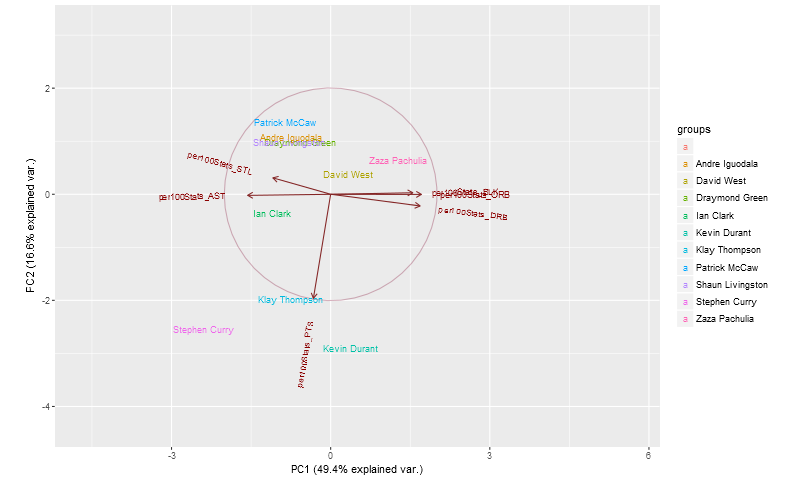

In [420]:
%%R -i labels -i data -w 800 -u px
pcaPlayerBiplot(labels, data)

Welp, this plot basically looks like a Fisher Price toy compared to the other one, but It's much more interpretable, and perhaps makes more logical sense. You got your same 3 main axis, but one is concentrated solely on points, and the other two are your guard / big men attributes. It may be a little less comprehensive, but we've eased up the number of contraints each player must fit into. Instead of trying to cram a paragraph into a 2 words, we're now trying to cram... a sentence into two words, and we're able to make the sentence out a bit better than we were able to with th paragraph.

KD, Steph, Klay, clearly your scorers.

Draymond Green and David West... take a look at their statlines man... they are BEASTS and they are still being reduced to where they are in the plot. They look nearly useless in the plot, but we're basically able to reinforce that that middle area within the plot just means _**balance**_. Whether they're averaging 0 TRB / 0 AST or 10 TRB / 10 AST, they're going to end up in that middle section. And therein lies one of the parts of the sentence we simply cannot reconstruct with two words...

If I'm trying to say "Want to go shopping with me and my sister at Main St. Mall at Noon?", something's gotta give. There's 3 pieces of information here... who, where, and when. I can say Mall / Noon? or Sister / Mall? or Sister / Noon? Regardless, we're goign to have to leave one out of those pieces of information, and within this plot, we're seeing the _**type**_ of player each of these guys are, but for all-around players, we're not able to see how well they're doing all of them at once. Our 2 dimensions will simply not allow for that.

One caveat, well maybe not caveat, but _**consideration**_, is that the regions we explored in the last post are now woefully incorrect. That whole region of spot up 3 guys is kinda gone because we don't have 3PA as a feature anymore. That region is now basically... guys who assist and steal and nothing else. In fact, let's check out the plot with the whole scatterplot again instead of just the names of the players and teams we're looking at.

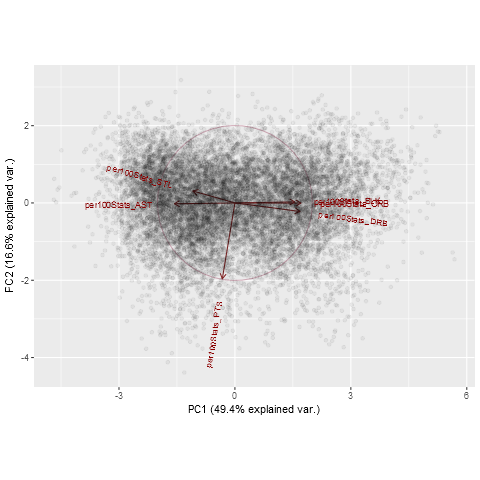

In [421]:
%%R -i data

pca = prcomp(data, center = T, scale = T)
ggbiplot(pca, obs.scale = 1, var.scale = 1, circle = TRUE, alpha = 0.05)

Looks like somewhat of a butterfly shape, still with two main clusters. Let's check out some other teams.

Okay, so I want to revisit my problem of that third dimension. I envision two roads to take:
- Keep our bi-plot as it is, but add a third dimension in terms of color or size to represent a more cumulatively encapsulating metric like PER, or maybe even just adding up PTS + REB + AST + STL + BLK or something like that.
- Make our bi-plot into a tri-plot. I'm not even sure if that exists, but worst case we can just manually graph the 3rd PC.

Should I try both? I don't know. I think the first solution provides a more interpretable chart whereas the second solution feels like it's opening up another pandora's box. I don't really know what that third dimension will look like in terms of PTS / RB / AST / STL / BLK and it may even provide an even less interpretable view. My gut feeling is that I like how interpretable this 2D bi-plot is right now, and some type of all-encapsulating metric would compliment it perfectly.

## Adding Metric For Third Dimension
Let's try option 1 first, and just use our metric as PTS + ORB + DRB + AST + STL + BLK. This way, at least fundamentally just thinking about it, should separate Draymond Greens of the world with the Shaun Livingstons of the world.

I think I'll just go with a label sizing proportional to the total of ORB + DRB + AST + STL + BLK. I don't really want to throw PTS in there because the PTS axis already describes it enough. My main motivation is to differentiate between the big man and guard attributes, so let's just throw those in there.

I'm also going to value DRB's at 80% of their full value because I feel like DRBs are much easier to come by than AST or ORB. I'm also going to value AST and STL as 2x their full value because these are a bit more valuable as well. These are somewhat arbitrary values so, as always... uhh... let's just accept these for now...

![](http://68.media.tumblr.com/cafe8f051ebe20cf290cb5664a4fbfc4/tumblr_n123zuHOy71rzik3go1_500.gif)

To create this graph, I think I have to do something a bit funky in R. I'm not sure what the inner workings of ggbiplot is, but I'm not sure if I can actually have variables sizes for points or labels.

In [564]:
# Define a function to take in a year and a team, the function will calculate who the starters are, perform the PCA transformation
#   and then plot the starters on the PCA plot
def teamPlayerReBiplotSize(seasonStartYear, team):
    # Select subset of features
    playerAggDfToAnalyzeMin10Min20GamesPCAFeatures = playerAggDfToAnalyzeMin10Min20Games[[
        'season_start_year',
        'perGameStats_Tm',
        'perGameStats_Player',
        'perGameStats_MP',
        'perGameStats_GS',
        'per100Stats_ORB',
        'per100Stats_DRB',
        'per100Stats_AST',
        'per100Stats_STL',
        'per100Stats_BLK',
        'per100Stats_PTS'
    ]].dropna().reset_index(drop = True)
    
    # Create a copy of the dataframe with shorter name for readability
    pcaFeaturesDf = playerAggDfToAnalyzeMin10Min20GamesPCAFeatures
    
    # Calculate the 5 players on the given team with the most games started, get their index into a list
    startersDfIndexes = pcaFeaturesDf[
        (pcaFeaturesDf['season_start_year'] == seasonStartYear) & (pcaFeaturesDf['perGameStats_Tm'] == team)
    ].sort_values(
        'perGameStats_MP',
        ascending = False
    ).head(10).index.tolist()
    
    # Print the starters statlines
    playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesStatlines = playerAggDfToAnalyzeMin10Min20GamesPCAFeatures[playerAggDfToAnalyzeMin10Min20GamesPCAFeatures.index.isin(startersDfIndexes)][[
        'perGameStats_Player',
        'perGameStats_MP',
        'per100Stats_PTS',
        'per100Stats_ORB',
        'per100Stats_DRB',
        'per100Stats_AST',
        'per100Stats_STL',
        'per100Stats_BLK'  
    ]]

    # For those players found, output them to the label to pass to ggbiplot, otherwise label to blank category
    playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesLabel = np.where(
        playerAggDfToAnalyzeMin10Min20GamesPCAFeatures.index.isin(startersDfIndexes),
        playerAggDfToAnalyzeMin10Min20GamesPCAFeatures['perGameStats_Player'],
        ''
    ).tolist()
    
    # For those players found, output sizes proportional to their PTS / TRB / AST / STL / BLK to size points / labels
    playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesSize = np.where(
        playerAggDfToAnalyzeMin10Min20GamesPCAFeatures.index.isin(startersDfIndexes),
        (
            playerAggDfToAnalyzeMin10Min20GamesPCAFeatures['per100Stats_ORB'] + 
            playerAggDfToAnalyzeMin10Min20GamesPCAFeatures['per100Stats_DRB'] * 0.8 + 
            playerAggDfToAnalyzeMin10Min20GamesPCAFeatures['per100Stats_AST'] + 
            playerAggDfToAnalyzeMin10Min20GamesPCAFeatures['per100Stats_STL'] * 2 + 
            playerAggDfToAnalyzeMin10Min20GamesPCAFeatures['per100Stats_BLK'] * 2
        ) / 5,
        0
    ).tolist()
    
    # Structure data to pass to R's prcomp()
    playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesData = playerAggDfToAnalyzeMin10Min20GamesPCAFeatures.drop(['season_start_year', 'perGameStats_Tm', 'perGameStats_Player', 'perGameStats_GS', 'perGameStats_MP'], 1)
    
    # Return labels and data to pass to R
    return playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesStatlines, playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesSize, playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesLabel, playerAggDfToAnalyzeMin10Min20GamesPCAFeaturesData

In [565]:
%%R

pcaPlayerBiplotSize = function(sizes, labels, data){
    pca = prcomp(data, center = T, scale = T)
    ggbiplot(pca, obs.scale = 1, var.scale = 1, circle = TRUE, alpha = 1, labels = labels, labels.size = sizes)
}

In [566]:
statlines, size, labels, data = teamPlayerReBiplotSize(2016, 'GSW')
statlines

,perGameStats_Player,perGameStats_MP,per100Stats_PTS,per100Stats_ORB,per100Stats_DRB,per100Stats_AST,per100Stats_STL,per100Stats_BLK
12334,Ian Clark,14.7,22.6,1.0,4.1,3.8,1.6,0.3
12346,Stephen Curry,33.5,36.5,1.1,5.3,9.5,2.6,0.3
12367,Kevin Durant,33.5,35.9,0.9,11.0,7.0,1.5,2.3
12407,Draymond Green,32.5,15.1,1.9,9.8,10.4,3.0,2.0
12450,Andre Iguodala,26.3,13.8,1.2,6.1,6.3,1.8,0.9
12504,Shaun Livingston,17.7,14.1,1.0,4.4,5.0,1.3,0.7
12516,Patrick McCaw,14.9,12.4,0.9,3.5,3.5,1.5,0.6
12560,Zaza Pachulia,18.2,16.1,5.2,10.2,5.0,2.3,1.2
12629,Klay Thompson,34.1,31.7,0.9,4.3,2.9,1.2,0.7
12653,David West,12.5,18.0,2.5,8.9,8.6,2.3,2.8


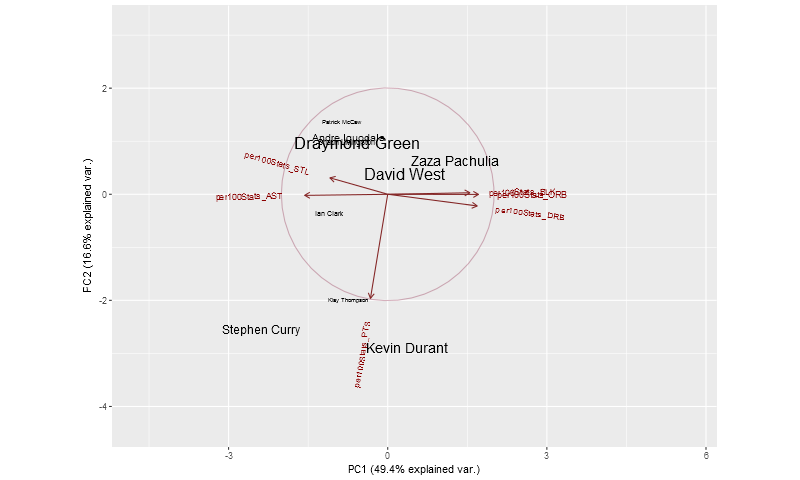

In [567]:
%%R -i size -i labels -i data -w 800 -u px
pcaPlayerBiplotSize(size, labels, data)

Nevermind. We good. It wasn't that hard in R. ggbiplot came with a _**labels.size**_ attribute that took a list just like _**group**_ did. Actually, for some reason I can't put on a label sizes _**WHILE**_ also grouping and therefore coloring... I can't really figure it out at the moment, but I don't actually need colours right now as the names are enough.

There we go though. Draymond is now _**clearly**_ set apart from the likes of Dre and Patrick McCrae. Green's name even gathers attention over Steph and KD depending on what you're looking at. This is exactly what I'm looking for as well, becaues Draymond's putting together a goddamn 15 / 12 / 10 / 3 / 2 on PTS / TRB / AST / STL / BLK, and that _**DESERVES**_ attention.

David West and Zaza are also beasting in that middle region apparently.

Let's check out some other teams as well.

## 2015 CLE

In [568]:
statlines, size, labels, data = teamPlayerReBiplotSize(2015, 'CLE')
statlines

,perGameStats_Player,perGameStats_MP,per100Stats_PTS,per100Stats_ORB,per100Stats_DRB,per100Stats_AST,per100Stats_STL,per100Stats_BLK
11920,Matthew Dellavedova,24.6,15.7,0.9,3.6,9.3,1.2,0.2
12021,Kyrie Irving,31.5,32.1,1.4,3.5,7.7,1.7,0.6
12024,LeBron James,35.6,36.5,2.1,8.6,9.8,2.0,0.9
12026,Richard Jefferson,17.9,15.9,0.6,4.4,2.3,1.3,0.5
12077,Kevin Love,31.5,26.2,3.2,13.0,3.9,1.2,0.9
12114,Timofey Mozgov,17.4,18.4,4.3,8.8,1.3,0.9,2.2
12182,Iman Shumpert,24.4,12.2,1.3,6.7,3.6,2.1,0.7
12190,J.R. Smith,30.7,20.8,0.9,3.8,2.8,1.8,0.5
12213,Tristan Thompson,27.7,14.6,6.1,10.7,1.4,0.9,1.2
12247,Mo Williams,18.2,23.3,0.4,4.5,6.7,1.0,0.3


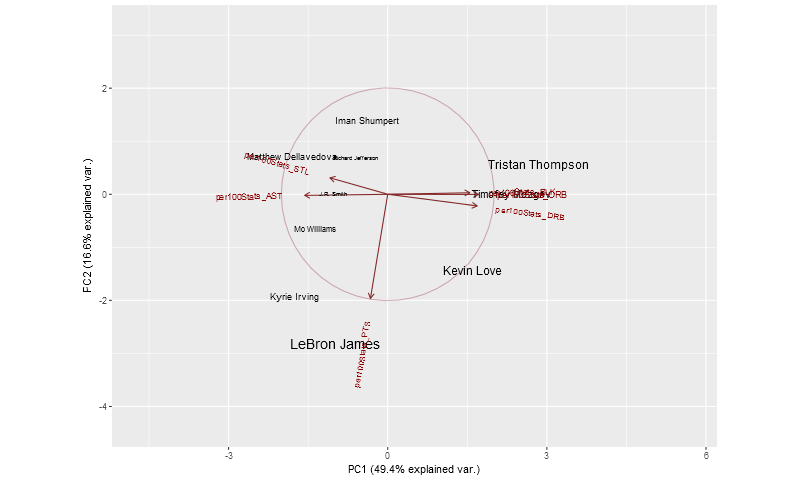

In [569]:
%%R -i size -i labels -i data -w 800 -u px
pcaPlayerBiplotSize(size, labels, data)

I'm liking this third dimension. A lot more information can be told from the same plot.

Lebron, Lebron, Lebron. He's basically the Draymond of CLE except he also leads them in scoring and he's doing it at an extremely efficient rate. Sorry, I just called Lebron the "Draymond" of something. That's just wrong, and I apologize for that. My point is that they're both in the middle of the plot in terms of guard / big men attributes and they both do A LOT of both.

Kyrie and Kevin Love are also scoring at a pretty elite rate (well, Kyrie is), and They got a few other guys Mo Williams, JR, and Timofey Mozgov that are also scoring at a pretty efficient rate.

Look how small the text is on JR as well lol, he's basically doing nothing but scoring.

Tristan Thompson and Kevin Love are doing work on the big men end, grabbing a ton of boards each, and you got Delly who looks like a great backup point guard as well.

## 2016 HOU

In [570]:
statlines, size, labels, data = teamPlayerReBiplotSize(2016, 'HOU')
statlines

,perGameStats_Player,perGameStats_MP,per100Stats_PTS,per100Stats_ORB,per100Stats_DRB,per100Stats_AST,per100Stats_STL,per100Stats_BLK
12270,Ryan Anderson,29.4,22.2,2.6,5.0,1.5,0.7,0.3
12273,Trevor Ariza,34.6,16.1,0.9,7.1,3.0,2.6,0.3
12296,Patrick Beverley,30.7,14.9,2.1,7.0,6.5,2.3,0.6
12323,Clint Capela,23.8,25.1,5.5,10.8,2.0,1.0,2.4
12351,Sam Dekker,18.4,17.0,3.2,6.4,2.6,1.3,0.7
12401,Eric Gordon,31.0,25.2,0.6,3.6,3.9,1.0,0.8
12414,James Harden,36.4,38.4,1.5,9.1,14.7,1.9,0.6
12416,Montrezl Harrell,18.3,23.8,3.7,6.2,2.9,0.9,1.9
12435,Nene Hilario,17.9,24.4,3.8,7.5,2.6,2.2,1.6
12668,Lou Williams,25.7,28.5,1.0,4.5,4.4,1.2,0.8


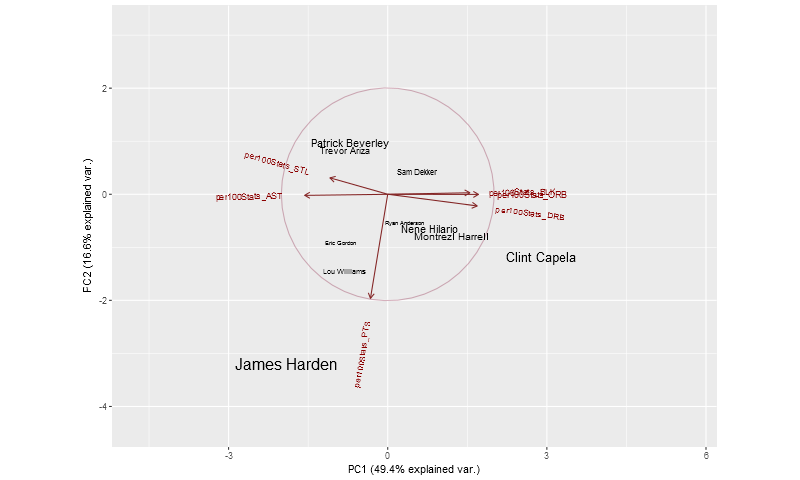

In [571]:
%%R -i size -i labels -i data -w 800 -u px
pcaPlayerBiplotSize(size, labels, data)

Lol, here, Lebron is the _**JAMES HARDEN**_ of CLE!! Okay apologize to the King again, but look at James Friggin Harden man. He's doing it all for his team.

Observations:
- James Harden is nuts
- Look at their **scoring power**... Harden, Lou Will, Eric Gordon, Clint, Harrell, Nene, Ryan Anderson... all scoring at a very efficient rate
- I really didn't know Clint Capela was that efficient of a big man... he basically embodies the big man here... **25 / 16 / 2.5 on PTS / TRB / BLK**.
- I heard so much about Trevor Ariza all year... doesn't look like he's that crazy of a contributor, or even scorer

## 2016 OKC

In [572]:
statlines, size, labels, data = teamPlayerReBiplotSize(2016, 'OKC')
statlines

,perGameStats_Player,perGameStats_MP,per100Stats_PTS,per100Stats_ORB,per100Stats_DRB,per100Stats_AST,per100Stats_STL,per100Stats_BLK
12258,Steven Adams,30.1,18.5,5.8,6.8,1.8,1.8,1.6
12397,Taj Gibson,21.1,20.5,3.7,6.4,1.4,1.5,1.4
12404,Jerami Grant,19.1,13.6,1.3,5.2,1.5,1.1,2.5
12479,Enes Kanter,21.3,33.2,6.3,9.2,2.1,1.0,1.2
12521,Doug McDermott,19.5,16.6,0.7,4.9,1.5,0.2,0.1
12538,Anthony Morrow,15.7,18.0,0.9,1.4,1.5,1.6,0.2
12557,Victor Oladipo,33.3,23.6,0.9,5.6,3.9,1.7,0.4
12587,Andre Roberson,30.1,10.8,2.0,6.3,1.6,1.9,1.6
12601,Domantas Sabonis,20.2,14.5,1.4,7.3,2.5,1.1,1.0
12654,Russell Westbrook,34.8,45.1,2.4,12.7,14.7,2.3,0.5


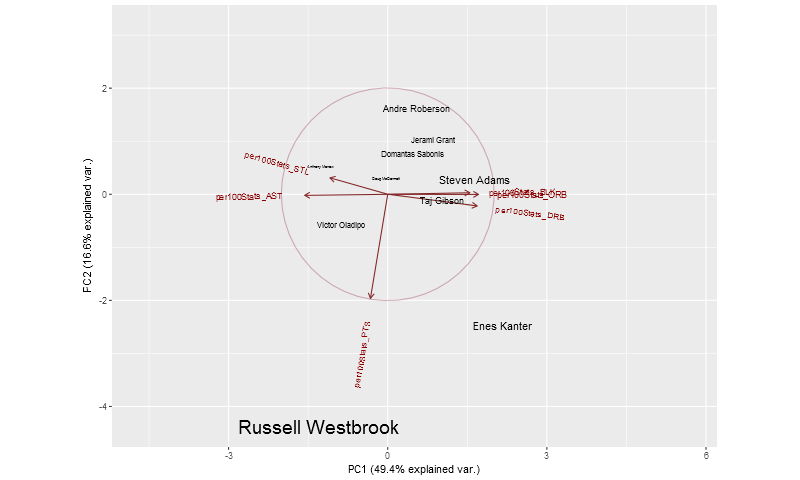

In [573]:
%%R -i size -i labels -i data -w 800 -u px
pcaPlayerBiplotSize(size, labels, data)

In contrast... wow. Rus. Sel. West. Brook. I thought James Harden was going nuts here. This guy is nowhere near the unit circle anymore. We all know what Russ is doing there year, so let's move on.

First contrast with HOU. Russ' scoring power is basically either 1) making up for or 2) taking away from anyone else's. Kanter and Oladipo are contributing in terms of scoring efficiency (Kanter with only 21 minutes though). But no one else is really even worth mentioning.

We also got alot of guys who are not scoring and are not doing too much of anything like Doug McDermott and Anthony Morrow.

_**Double Take**_ - Wow, Kanter's numbers are actually pretty insane.

## 1995 CHI

In [577]:
statlines, size, labels, data = teamPlayerReBiplotSize(1995, 'CHI')
statlines

,perGameStats_Player,perGameStats_MP,per100Stats_PTS,per100Stats_ORB,per100Stats_DRB,per100Stats_AST,per100Stats_STL,per100Stats_BLK
4365,Ron Harper,23.6,16.6,2.1,3.9,5.8,2.9,0.9
4391,Michael Jordan*,37.7,42.5,2.5,6.7,6.0,3.1,0.7
4395,Steve Kerr,23.4,18.9,0.7,2.3,5.3,1.7,0.1
4403,Toni Kukoc,26.0,26.7,2.9,5.2,7.2,1.6,0.7
4416,Luc Longley,26.5,18.1,3.3,6.9,3.8,0.7,2.7
4496,Scottie Pippen*,36.7,27.9,2.8,6.4,8.4,2.5,1.1
4526,Dennis Rodman*,32.6,8.9,9.0,15.0,4.0,0.9,0.7
4546,Dickey Simpkins,11.4,16.6,5.1,6.9,2.9,0.7,0.6
4587,Bill Wennington,15.0,18.6,2.9,5.7,2.3,1.0,0.8


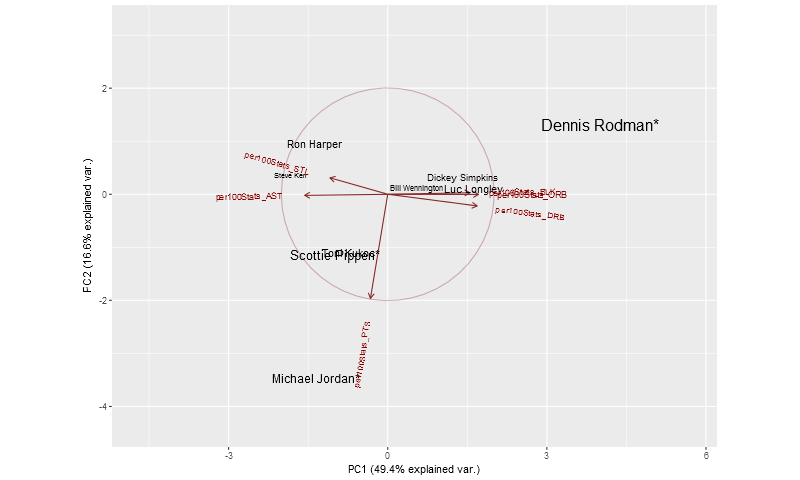

In [578]:
%%R -i size -i labels -i data -w 800 -u px
pcaPlayerBiplotSize(size, labels, data)

MJ, Scottie, and Rodman all beasting here. Rodman, though, seriously.

Given that we have MJ as a killer scorer, look at all the added value that Rodman is giving them. Wow. He's not scoring much, but they got enough guys floating at that elite level and that 20 PTS / 100 poss level to stay afload.

You also got pretty efficient role players in Harper, Longley, and Kukoc.

## 2000 Lakers

In [580]:
statlines, size, labels, data = teamPlayerReBiplotSize(2000, 'LAL')
statlines

,perGameStats_Player,perGameStats_MP,per100Stats_PTS,per100Stats_ORB,per100Stats_DRB,per100Stats_AST,per100Stats_STL,per100Stats_BLK
5774,Kobe Bryant,40.9,36.4,2.0,5.5,6.4,2.1,0.8
5840,Rick Fox,27.9,18.0,1.8,5.6,6.0,1.6,0.7
5853,Horace Grant,31.0,14.4,4.8,7.1,2.6,1.1,1.3
5860,Ron Harper,24.2,14.1,2.1,5.5,5.2,1.8,1.1
5873,Robert Horry,20.1,13.4,3.1,6.7,4.2,1.8,1.8
5925,Tyronn Lue,12.3,14.5,0.6,3.0,5.0,2.1,0.0
5985,Shaquille O'Neal*,39.5,38.0,5.2,11.6,5.0,0.8,3.7
6003,Mike Penberthy,16.1,16.4,0.6,3.3,4.4,1.4,0.1
6026,Isaiah Rider,18.0,22.0,1.9,4.9,4.8,1.2,0.3
6043,Brian Shaw,22.9,12.0,1.4,7.3,7.4,1.4,0.8


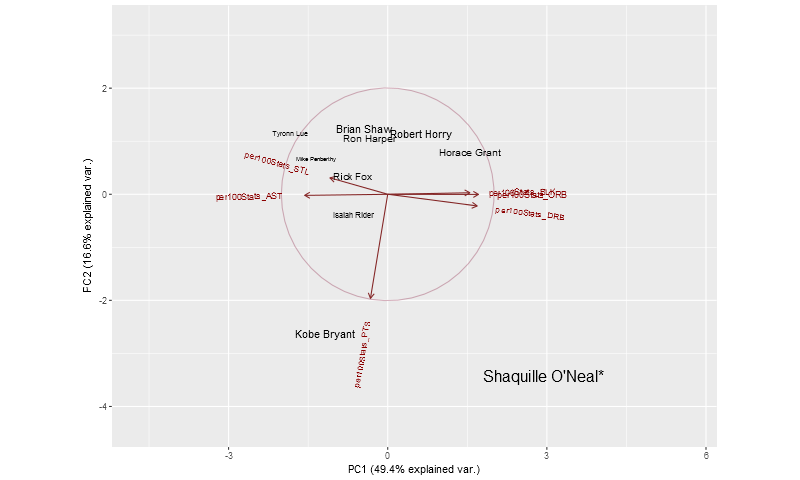

In [581]:
%%R -i size -i labels -i data -w 800 -u px
pcaPlayerBiplotSize(size, labels, data)

Lol I dunno man... it's interesting seeing some of these historical teams. The story here, I guess, is Kobe and Shaq. Shaq was kind of... your everything. Kobe was also scoring at such an elite level. You also got guys like Brian Shaw, Harper, and Horry who were also giving you a bit of everything at an efficient rate.

What's the correlation here though... or rather... is it correlation or causation? Were they solid role players because they they played with Kobe and Shaq? Or were Kobe and Shaq even better becaues these guys were such good role players? Or is there no correlation at all and they just assembled two superstars with some very good role players? Some things to keep in the back of my mind...

## 2007 Celtics

In [582]:
statlines, size, labels, data = teamPlayerReBiplotSize(2007, 'BOS')
statlines

,perGameStats_Player,perGameStats_MP,per100Stats_PTS,per100Stats_ORB,per100Stats_DRB,per100Stats_AST,per100Stats_STL,per100Stats_BLK
8463,Ray Allen,35.9,25.6,1.5,3.9,4.5,1.3,0.3
8464,Tony Allen,18.3,19.0,1.3,5.2,4.4,2.4,0.8
8548,Glen Davis,13.6,17.6,5.3,6.3,1.6,1.7,1.1
8589,Kevin Garnett,32.8,30.3,3.1,11.8,5.5,2.3,2.0
8632,Eddie House,19.0,20.8,0.7,5.3,5.4,2.1,0.4
8750,Kendrick Perkins,24.5,15.0,4.0,9.1,2.3,0.9,3.1
8753,Paul Pierce,35.9,28.8,1.0,6.6,6.7,1.9,0.7
8755,James Posey,24.6,15.8,0.9,8.5,3.3,2.1,0.6
8756,Leon Powe,14.4,29.0,6.2,8.6,1.0,1.0,1.0
8770,Rajon Rondo,29.9,18.6,1.8,5.6,9.0,3.0,0.3


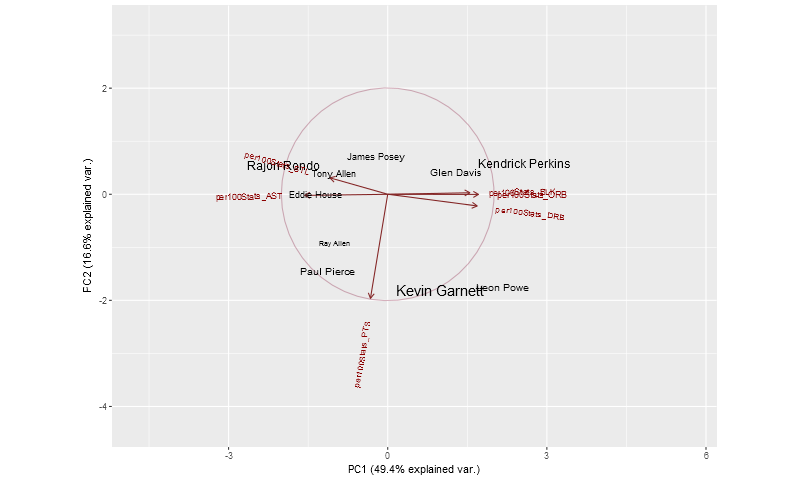

In [583]:
%%R -i size -i labels -i data -w 800 -u px
pcaPlayerBiplotSize(size, labels, data)

Man, that triangle of KG, Rondo, and Perkins. Such efficiently dependable guys. Throw in PP and Ray as well and... Leon Powe wtf? Anyways, what strikes me here is the **balance** of duties and scoring here. You don't really have anyone outside of that unit circle, but look at all those other guys who are sitting in the middle contributing to not only scoring but everything else as well. You got your 3 guys who can all score efficiently (Powe only played 14 mins per game lol) but you got everyone else who could also score efficiently when called upon.

## 2003 DET

In [584]:
statlines, size, labels, data = teamPlayerReBiplotSize(2003, 'DET')
statlines

,perGameStats_Player,perGameStats_MP,per100Stats_PTS,per100Stats_ORB,per100Stats_DRB,per100Stats_AST,per100Stats_STL,per100Stats_BLK
6859,Chucky Atkins,18.8,18.1,0.4,3.1,6.9,1.4,0.1
6879,Chauncey Billups,35.4,26.1,0.7,4.8,8.8,1.7,0.2
6985,Richard Hamilton,35.5,27.1,1.5,4.0,6.1,2.0,0.3
7014,Lindsey Hunter,20.0,9.7,1.1,4.5,7.0,3.2,0.5
7028,Mike James,19.7,17.6,0.9,5.3,10.1,2.8,0.1
7126,Mehmet Okur,22.3,23.6,5.5,9.0,2.4,1.2,2.2
7151,Tayshaun Prince,32.9,17.0,1.9,6.0,3.9,1.3,1.4
7225,Ben Wallace,37.7,13.8,5.8,12.2,2.5,2.6,4.4
7228,Rasheed Wallace,30.6,24.5,2.6,10.0,3.2,1.9,3.7
7259,Corliss Williamson,19.9,26.1,3.1,5.8,2.0,1.0,0.7


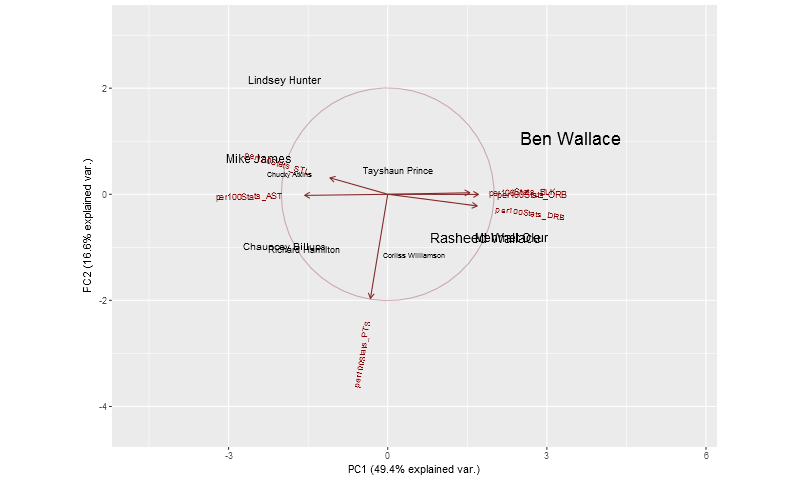

In [585]:
%%R -i size -i labels -i data -w 800 -u px
pcaPlayerBiplotSize(size, labels, data)

This is another story of balance and defense. You can't even really say who the leading scorer was. They _**all**_ scored efficiently in the PTS axis of the plot. Then you got a guy like big ben anchoring the dirty work... and a Mike James and Lindsey Hunter suffocating on defense as well (2.8 and 3.2 STL / 100 poss... jeez).

If a team like HOU wins the cup this year, it'll just be so wide open as to exactly how yo ucan structure your team and still win...

## 2009 PHO

In [587]:
statlines, size, labels, data = teamPlayerReBiplotSize(2009, 'PHO')
statlines

,perGameStats_Player,perGameStats_MP,per100Stats_PTS,per100Stats_ORB,per100Stats_DRB,per100Stats_AST,per100Stats_STL,per100Stats_BLK
9284,Lou Amundson,14.8,16.0,5.5,9.4,1.3,1.0,3.1
9299,Leandro Barbosa,17.9,26.8,0.7,3.7,4.1,1.5,0.8
9381,Goran Dragic,18.0,22.2,1.3,4.6,8.4,1.7,0.3
9382,Jared Dudley,24.3,17.0,2.5,4.6,2.9,2.0,0.4
9402,Channing Frye,27.0,20.8,1.5,8.3,2.6,1.5,1.7
9445,Grant Hill,30.0,18.9,1.5,7.7,4.0,1.2,0.7
9510,Robin Lopez,19.3,22.0,5.3,7.4,0.4,0.5,2.7
9551,Steve Nash,32.8,25.2,0.6,4.4,16.9,0.8,0.2
9590,Jason Richardson,31.5,25.1,1.6,6.5,2.9,1.3,0.7
9626,Amar'e Stoudemire,34.6,33.6,4.1,8.9,1.5,0.9,1.5


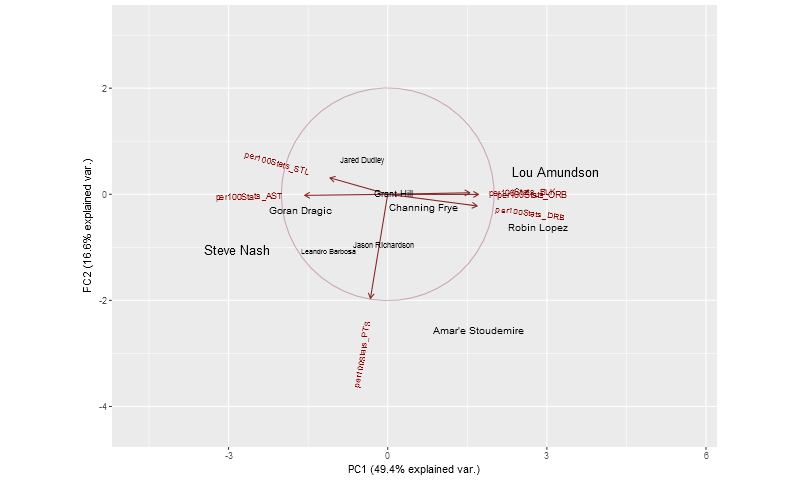

In [588]:
%%R -i size -i labels -i data -w 800 -u px
pcaPlayerBiplotSize(size, labels, data)

Scoring, scoring, scoring with... wait... Lou Amundson anchoring the defense? He only played 14 minutes per game lol, but WOW what an efficient 14 minutes that was haha.

## I'm Tired...
That's probably enough for now... I'm pretty tired lol. This is interesting looking at some of the greatest teams in history + random 2016 teams. I think what would also help me understand the makeup of a team and how teams become successful is to look at an entire spectrum of teams. Next, I'm going to look at all the 2016 teams so I can get a sense of the good, the bad, and the ugly.